# Lets reproduce a model which does the following 

<img src = "https://i.imgur.com/6NMdO9u.png" width = 50%>

# I will be using the MNIST Dataset
---
lets prepare the data

In [0]:
# imports 
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [0]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [14]:
print(len(mnist))

60000


In [15]:
img, label = mnist[0]
print(f"the shape of an image {img.shape}")

the shape of an image torch.Size([1, 28, 28])


## To display an image 
---
we need to denormalize and change it to the correct format (h,w,c)

In [0]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

In [0]:
def show_img(img, label=None):
  img = denorm(img)
  plt.imshow(img[0], cmap='gray')
  if label:
    plt.title(label)

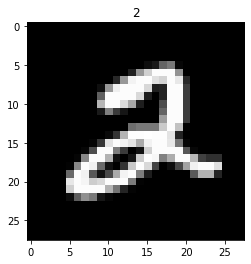

In [18]:
img, label = mnist[5]
show_img(img, label)

### lets load the data into a dataloader (to shuffle and batch the data)
---

In [0]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device selected {device}")

Device selected cuda


## Cool, lets continue and start building the netWORK
---
### Discrimiator Network

In [0]:
image_size = 784
hidden_size = 256

In [0]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [0]:
D.to(device);

### Now the Generator Network

In [0]:
latent_size = 64

In [0]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [0]:
G.to(device);

In [27]:
print(D)
print(G)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)
Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Lets look at what our Generate output might look at right at the start

## Okaaaaay! Lets start training these models
---
### Discriminator Training

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [0]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

# Discriminator training process
---

- create a batch of ones to compare against predictions for actual images
- create a batch of zeros to compare against predictions for generated images
- Feed the actual images into the network and compute BCE loss against true labels 
- Generate a image of the same dimensions and batch size with the help of the Generator
- Feed this Generated image into the Discriminator and compute BCE loss against the fake labels
- Add the two losses 
- Preform gradient decent and update model weights
 

In [0]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

### Using the above mentioned code the Discriminator is gonna train, to maximize its potential to tell the difference between an actual image and fake one
---
### Now lets write the code to train the Generate to try and fool the Discriminator

In [0]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Generator Training process: 
---

- Generate a noise of the latent size and the provided batch size 
- Feed this into the Generator Network and retrive an image
- Feed this image into to the Decrimination network and compute BCE loss against the output of that network to true labels (we are trying to train to the best ability to fool the Discrimination Network)
- Perform gradient descent and update model weights


In [0]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Training the whole deal
---

In [0]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

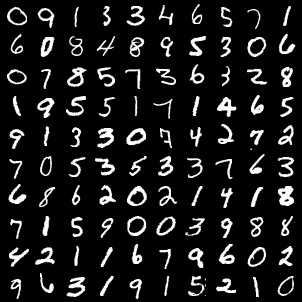

In [34]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

### Defining a helper function to save the generated image to disk
---

Saving fake_images-0000.png


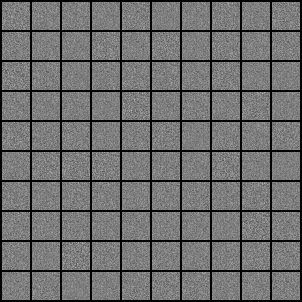

In [35]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# LEGGO

In [36]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0420, g_loss: 4.3720, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.2499, g_loss: 4.7295, D(x): 0.90, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.0458, g_loss: 5.8262, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3593, g_loss: 4.0272, D(x): 0.91, D(G(z)): 0.18
Epoch [1/300], Step [400/600], d_loss: 0.0298, g_loss: 5.7531, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.2228, g_loss: 5.6818, D(x): 0.92, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3398, g_loss: 3.0987, D(x): 0.95, D(G(z)): 0.21
Epoch [2/300], Step [400/600], d_loss: 0.7147, g_loss: 2.9497, D(x): 0.80, D(G(z)): 0.31
Epoch [2/300], Step [600/600], d_loss: 0.4815, g_loss: 2.9802, D(x): 0.89, D(G(z)): 0.17
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3218, g_loss: 4.1019, D(x): 0.89, D(G(z)): 0.14
Epoch [3/300], Step [400/6

In [0]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

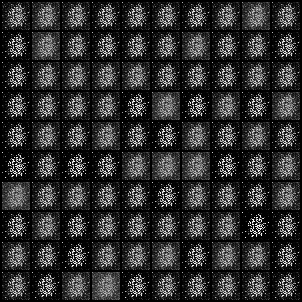

In [38]:
Image('./samples/fake_images-0001.png')

In [39]:
Image('./samples/fake_images-00011.png')

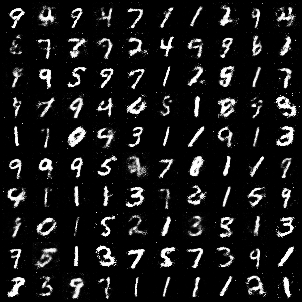

In [40]:
Image('./samples/fake_images-0111.png')

In [41]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'training_proc.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('training_proc.avi')

/content/training_proc.avi

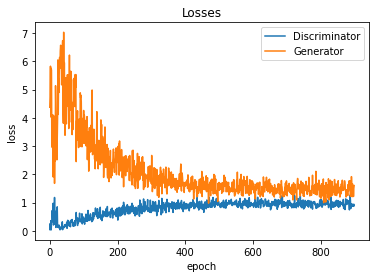

In [42]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

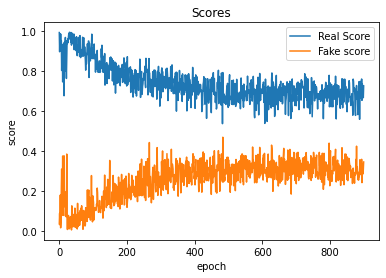

In [43]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');